In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the noise curve

Before we can do any actual analysis we need to a choose noise curve/PSD/ASD to use. There are lots of analytically calculated noise curves that can be found at . But for analysis on real data we typically want to infer the PSD from the data.

For analysis performed in O1 it was typically to use a PSD that was a fourier transform of the data with appropriate processing. In O2 it was decided that a fitted PSD would be used for analysis where a function is fitted to the fourier transformed data using BayesWave. As Vivien has often said, "This is an inference task in it self".

If you are only performing a single analysis, then you don't need to follow the rest of this tutorial. By default, if you don't provide a PSD or ASD when you start a parameter estimation job then you can ask BayesWave to generate a PSD and it will use that. However if you are performing multiple analyses then it is important to use the same PSD for each analysis so you should generate a single PSD that all analyses can use.

To genereate the PSD for the rerun analysis for GW150914 the `bayeswave_post` method was use as described under [*Method 1: Use BayesWave_Post*](https://www.lsc-group.phys.uwm.edu/ligovirgo/cbcnote/ParameterEstimationModelSelection/O2_PE/BayesWaveMedianPSD#Method_1:_Use_BayesWave_Post). Lets go through each of the steps

1. **Start a PE run**

   We need to start a PE job to generate a PSD. The configuration file for this Job can be found at `pe/GW150914_psd.ini`. You should go into the file and modify the following variables for your own user and the cluster you are using
   
   ```
   accounting_group_user
   webdir
   baseurl
   mpirun
   H1-spcal-envelope
   L1-spcal-envelope
   email
   ```

   Most of these are simply changing the paths so that they point to locations in you own user area on the cluster you are using. The only one that is different is the `mpirun` variable. This one is different for most LIGO clusters. If you don't know what this value should be then you can ask through one of the help routes described in [`README.ipynb`](README.ipynb).

   Once you have done this you are ready to start the job

   ```
   ~cbc/pe/lalinference_o2.sh
   cd /path/to/lalinference-tutorial/pe
   lalinference_pipe -r ./GW150914_psd GW150914_psd.ini
   ``` 
   
   The first line activates the O2 production environment for `lalinference`. Like using a consitent PSD, it is important to use consitent programs to perform multiple analyses of the same data. If you decided to use a different environment then you also need to update all the variables under the `condor` section in the `*ini` files.
   
2. **Wait for the PSD to be generated**

   You have to now wait for the appropriate data to be generated before you can continue. We can monitor the `log` directory to know when the data has been generated
   
   ```
   watch -n 10 ls /path/to/lalinference-tutorial/pe/GW150914_psd/lalinferencemcmc/IMRPhenomPv2pseudoFourPN/log
   ```
   
   When files called `lalinference-*****.err` appear then you can stop the Job that is running.
   
3. **Stop the job**

   Find out the id of the job
   
   ```
   condor_q -nobatch -dag
   ```
   
   and the kill the job
   
   ```
   condor_rm id-of-the-job
   ```

4. **Run the first post processing step to generate PSD files**

   You can follow the remaining steps described in [*Method 1: Use BayesWave_Post*](https://www.lsc-group.phys.uwm.edu/ligovirgo/cbcnote/ParameterEstimationModelSelection/O2_PE/BayesWaveMedianPSD#Method_1:_Use_BayesWave_Post). You can use `grep` and `sed` to generate a bash script that you can run to perform most of the remaining steps

   ```
   cd /path/to/lalinference-tutorial/pe/GW150914_psd/lalinferencemcmc/IMRPhenomPv2pseudoFourPN/
   grep 'bayeswave' lal*sh > bayeswave_post.sh
   sed -i 's/bayeswave /bayeswave_post /g' bayeswave_post.sh
   sed -i 's/--checkpoint/--checkpoint --0noise/g' bayeswave_post.sh
   chmod 700 bayeswave_post.sh
   ./bayeswave_post.sh
   ```
   
   However it is generally good practice not to run potentially costly programs on the head nodes on a cluster. Example submission scripts can be found in `pe/psd/*sub` for each IFO that needs to be processed.
   
5. **Run the second post processing step to generate normalised PSD files for lalinference**

   ```
   cd /path/to/lalinference-tutorial/pe/psd/
   ./BWP2LALInferencePSD.py -s 8 -i H1 -d /path/to/lalinference-tutorial/pe/GW150914_psd/lalinferencemcmc/IMRPhenomPv2pseudoFourPN/ROQdata/0/BayesWave_PSD_H1_post/clean_median_PSD.dat.0
   ./BWP2LALInferencePSD.py -s 8 -i L1 -d /path/to/lalinference-tutorial/pe/GW150914_psd/lalinferencemcmc/IMRPhenomPv2pseudoFourPN/ROQdata/0/BayesWave_PSD_L1_post/clean_median_PSD.dat.0
   ```

# Analysing the noise curve

Now that we have generated the noise curve, it is always good practise to compare to what others have done before. Below is some example plotting code derived from code written by Christopher Berry that plots the noise curves that we generate together with noise curves that had been used for O1 analysis of GW150914.

## H1

In [ ]:
H1_fit = np.loadtxt('../pe/psd/BayesWave_median_PSD_H1.dat')
H1_nofit_vivien = np.loadtxt('/home/spxvr1/ER8/G184098/20_mcmc_IMRPhenomPv2_no_on/run/lalinferencemcmc-0-H1L1-1126259462.39-0H1-PSD.dat')
H1_nofit_carl = np.loadtxt('/home/spxcjh/projects/O1_C02_reruns/G184098/IMRPhenomPv2_noPSDfit_SplineCal_nest/lalinferencenest-0-H1L1-1126259462.39-0.datH1-PSD.dat')

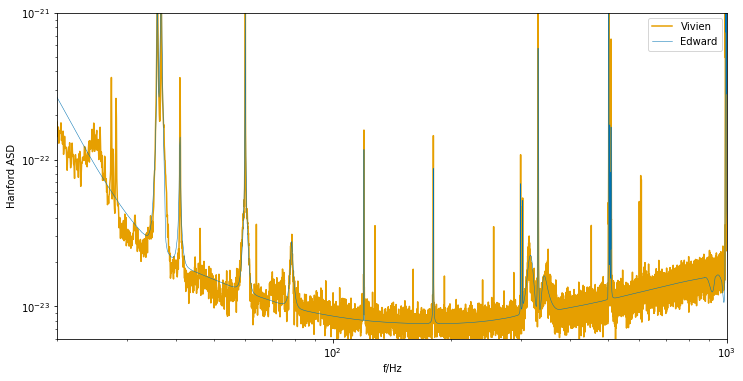

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.loglog(H1_nofit_vivien.T[0], np.sqrt(H1_nofit_vivien.T[1]), color='#e69f00', label='Vivien')
ax.loglog(H1_fit.T[0], np.sqrt(H1_fit.T[1]), color='#0072b2', label='Edward', lw=0.5)
ax.set_xlabel('f/Hz')
ax.set_ylabel('Hanford ASD')
ax.set_ylim((6e-24,1e-21))
ax.set_xlim((20,1e3))
ax.legend()
plt.show()
plt.close(fig)

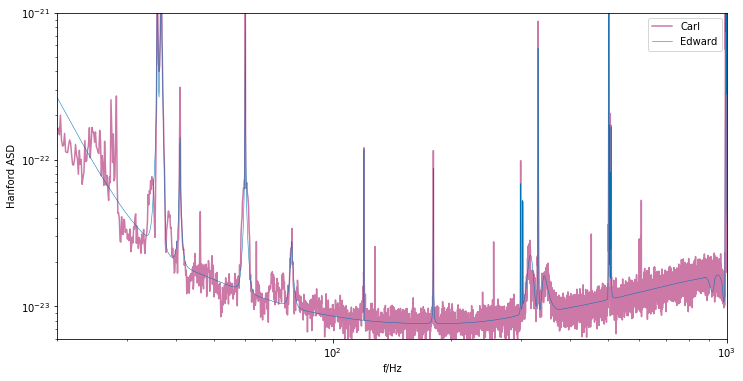

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.loglog(H1_nofit_carl.T[0], np.sqrt(H1_nofit_carl.T[1]), color='#cc79a7', label='Carl')
ax.loglog(H1_fit.T[0], np.sqrt(H1_fit.T[1]), color='#0072b2', label='Edward', lw=0.5)
ax.set_xlabel('f/Hz')
ax.set_ylabel('Hanford ASD')
ax.set_ylim((6e-24,1e-21))
ax.set_xlim((20,1e3))
ax.legend()
plt.show()
plt.close(fig)

## L1

In [35]:
L1_fit = np.loadtxt('../pe/psd/BayesWave_median_PSD_L1.dat')
L1_nofit_vivien = np.loadtxt('/home/spxvr1/ER8/G184098/20_mcmc_IMRPhenomPv2_no_on/run/lalinferencemcmc-0-H1L1-1126259462.39-0L1-PSD.dat')
L1_nofit_carl = np.loadtxt('/home/spxcjh/projects/O1_C02_reruns/G184098/IMRPhenomPv2_noPSDfit_SplineCal_nest/lalinferencenest-0-H1L1-1126259462.39-0.datL1-PSD.dat')

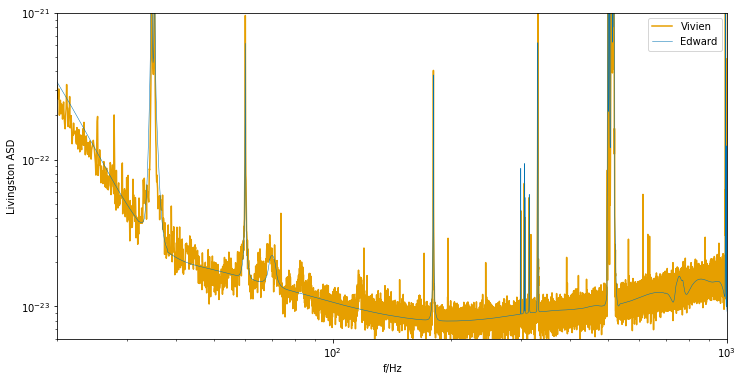

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.loglog(L1_nofit_vivien.T[0], np.sqrt(L1_nofit_vivien.T[1]), color='#e69f00', label='Vivien')
ax.loglog(L1_fit.T[0], np.sqrt(L1_fit.T[1]), color='#0072b2', label='Edward', lw=0.5)
ax.set_xlabel('f/Hz')
ax.set_ylabel('Livingston ASD')
ax.set_ylim((6e-24,1e-21))
ax.set_xlim((20,1e3))
ax.legend()
plt.show()
plt.close(fig)

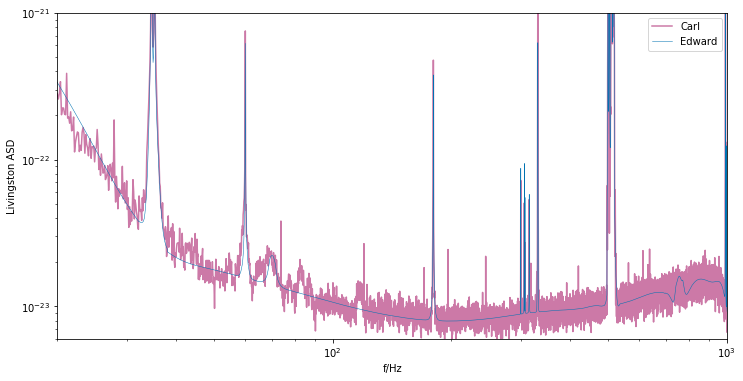

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.loglog(L1_nofit_carl.T[0], np.sqrt(L1_nofit_carl.T[1]), color='#cc79a7', label='Carl')
ax.loglog(L1_fit.T[0], np.sqrt(L1_fit.T[1]), color='#0072b2', label='Edward', lw=0.5)
ax.set_xlabel('f/Hz')
ax.set_ylabel('Livingston ASD')
ax.set_ylim((6e-24,1e-21))
ax.set_xlim((20,1e3))
ax.legend()
plt.show()
plt.close(fig)